# Ranking

ДЗ№2. LambdaRank или LambdaMART.
1. Нужно самостоятельно реализовать метрики ранжирования MAP, MRR, NDCG (вместо семинара).
2. Нужно реализовать алгоритм ранжирования LambdaRank или LambdaMART. Реализовать и то и другой будет плюсом. (см. ссылки ниже).
3. Протестировать алгоритм на «стандартных» датасэтах MQ2007 и MQ2008 https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/letor-4-0/ (вычислите метрики из пункта 1)
4. Применить алгоритм к дастасэту movielens https://grouplens.org/datasets/movielens/ . Считая, что оценка «5» – это релевантный фильм, «4» – это тоже релевантный фильм (но очевидно релевантность таких фильмов ниже, чем с оценкой «5»), остальные оценки не являются релевантными. Подумайте как адаптировать формат из "стандартных" датасэтов для ранжирования к задаче рекомендаций. Не поленитесь описать это комментарием в коде.
5. Если вы делали ДЗ №1 то сравнить, ранжирование из пункта 4 с результатами «своего» SVD, если не делали то можно сравнить результаты с «чужого» SVD (например из библиотеки https://implicit.readthedocs.io/en/latest/quickstart.html , https://surprise.readthedocs.io/en/stable/getting_started.html)
 Насколько «качество» (определите качество самостоятельно - обоснуйте выбор) отличается на топ-3, топ-5, топ-10 фильмов?

Ссылки:
1. Основная статья: https://proceedings.neurips.cc/paper/2006/file/af44c4c56f385c43f2529f9b1b018f6a-Paper.pdf (запасная ссылка: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/lambdarank.pdf )
2. Также полезно почитать:
https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf 
https://www.cs.cmu.edu/~pinard/Papers/sigirfp092-donmez.pdf 
3. Примеры с формулами (но без подробностей):
https://everdark.github.io/k9/notebooks/ml/learning_to_rank/learning_to_rank.html 
4. Можно повдохновляться кодом на «плюсах»:
https://github.com/microsoft/LightGBM/blob/e79716e0b69b27c8e6e2c39f59d0db7c63242f9a/src/objective/rank_objective.hpp

## Load Data

### Movielens

In [ ]:
# ! wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
# ! unzip ml-100k.zip

In [ ]:
import pandas as pd
import os


def load_movielens(fname, path='/home/ilya/repos/recsys/hw1/ml-100k'):
    path = os.path.join(path, fname)
    return pd.read_csv(path, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']).drop(columns=['timestamp'])

df = load_movielens('ua.base')
df.describe()

### MQ2007 и MQ2008

Ссылки:
- Описание датасетов, признаков и тп: [статья](https://arxiv.org/pdf/1306.2597.pdf)
- Скачать датасет: [LETOR 4.0](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/letor-4-0/)

In [1]:
from ranking.datasets import MQDataset
path = '../data/MQ2008/Fold2'
train_dataset = MQDataset(fold_path=path, split='train')
val_dataset = MQDataset(fold_path=path, split='vali')

In [2]:
train_dataset.dataset.head()

,relevance_label,qid,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,docid,inc,prob
0,0,11909.0,0.049554,0.0,0.0,0.000000,0.048537,0.0,0.0,0.0,...,0.682844,0.000000,0.000000,0.0,0.208262,0.089286,1.000000,GX000-01-8011551,1.000000,0.278009
1,0,11909.0,0.000000,0.0,0.4,0.166667,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.080000,0.0,0.000000,0.000000,0.000000,GX012-13-11604073,1.000000,0.081141
2,0,11909.0,0.012478,0.8,0.0,1.000000,0.014989,0.0,0.0,0.0,...,0.683032,1.000000,1.000000,0.0,1.000000,1.000000,0.166667,GX036-18-10002856,0.002252,0.109118
3,1,11909.0,0.049198,0.0,0.0,0.000000,0.048180,0.0,0.0,0.0,...,1.000000,1.000000,0.253333,0.0,0.040667,0.017857,0.000000,GX043-50-8139281,1.000000,0.256000
4,2,11909.0,0.252050,1.0,1.0,0.000000,0.254818,0.0,0.0,0.0,...,0.705649,0.333333,0.253333,0.0,0.004727,0.017857,0.527778,GX062-53-0946803,0.007940,0.205853


In [3]:
len(train_dataset)

354

In [3]:
from scipy.stats import pearsonr
df = train_dataset.dataset
x = df['relevance_label'].to_numpy()
y = df['inc'].to_numpy()
z = df['prob'].to_numpy()

corr1 = pearsonr(x, y)
corr2 = pearsonr(x, z)
corr3 = pearsonr(y, z)
print(corr1, corr2, corr3)

PearsonRResult(statistic=0.0571029456122412, pvalue=3.0023565646462906e-08) PearsonRResult(statistic=0.5750798594495724, pvalue=0.0) PearsonRResult(statistic=0.11115343735460118, pvalue=3.049911708873801e-27)


In [7]:
import numpy as np


for i, (f, t) in enumerate(train_dataset):
    if np.sum(t>0) == 0:
        print(i)

1
2
3
5
12
17
22
26
28
32
35
36
41
46
52
56
57
63
67
73
77
82
84
85
87
94
101
106
107
109
111
113
115
122
127
131
132
133
134
135
137
139
146
149
153
159
161
166
177
178
183
191
203
209
217
221
225
233
235
237
238
239
243
244
246
249
258
259
260
264
278
279
280
283
296
300
301
305
307
309
318
331
332
341
343
346
352
362
364
365
370
374
375
378
381
385
393
401
403
407
410
411
412
416
420
423
424
427
432
440
441
449
450
453
454
455
461


In [21]:
len(train_dataset), len(val_dataset)

(1017, 336)

In [14]:
df.drop(columns=['relevance_label', 'qid', 'docid']).to_list()

AttributeError: 'DataFrame' object has no attribute 'to_list'

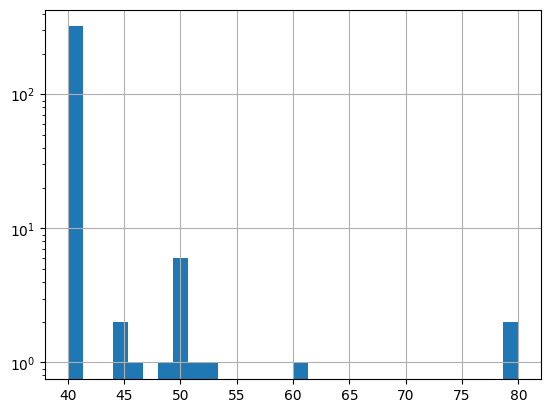

In [39]:
import matplotlib.pyplot as plt

plt.hist(df.groupby(by='qid')['docid'].count(), bins=30, log=True)
plt.grid()